In [3]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)
import os
from os.path import join
import random
import itertools
import datetime
import numpy as np
import pylab
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, TimeDistributed, Multiply, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from keras.layers import Reshape, Lambda, Flatten, Dropout, Concatenate, Permute, RepeatVector, GaussianNoise
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.recurrent import GRU, LSTM
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import cv2
from random import *
from math import pi
import hgtk
from PIL import ImageFont, Image, ImageDraw
from matplotlib import pyplot as plt
from collections import Counter
import datetime
import re
import OCR_utils as ocr

TensorFlow version: 1.10.0
Keras version: 2.2.0


In [2]:
random_seed=305
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

text_length = 15
save_model_path = './Generated_only.hdf5'

kor_train = np.loadtxt('./text/train_kor_words.txt', dtype = np.str)
kor_test = np.loadtxt('./text/test_kor_words.txt', dtype = np.str)
eng_train = np.loadtxt('./text/train_eng_words.txt', dtype = np.str)
eng_test = np.loadtxt('./text/test_eng_words.txt', dtype = np.str)

In [4]:
dictionary = ocr.load_dictionary()
font_path = "./fonts/"
font_list = os.listdir(font_path)

In [5]:
#해당 모델은 최대 15음소까지만 인식 가능하나 필요에 따라 늘릴 수 있음

K.clear_session()
img_h = 32
img_w = 128
n_layer = 3
label_length = len(ocr.load_dictionary())

# Network parameters
kernel_size = (3, 3)
input_shape = (img_h,img_w,1)
# batch_size = 32


input_data = Input(shape=input_shape, dtype='float32')
cnn_recurrent1 = Conv2D(64, (3,3), padding='same',activation='elu')
cnn_recurrent2 = Conv2D(128, (3,3), padding='same',activation='elu')
cnn_recurrent3 = Conv2D(256, (3,3), padding='same',activation='elu')
cnn_recurrent4 = Conv2D(512, (3,3), padding='same',activation='elu')
gap = GlobalAveragePooling2D()
flt = Flatten()
dropout = Dropout(0.3)


CNN = GaussianNoise(0.1)(input_data)
CNN = Conv2D(64, (7,7), padding='same',activation='elu')(CNN)
CNN = cnn_recurrent1(CNN)
CNN = cnn_recurrent1(CNN)
CNN = cnn_recurrent1(CNN)
CNN = BatchNormalization()(CNN)
CNN = MaxPooling2D((2,2))(CNN)
CNN = dropout(CNN)

CNN = Conv2D(128, (3,3), padding='same',activation='elu')(CNN)
CNN = cnn_recurrent2(CNN)
CNN = cnn_recurrent2(CNN)
CNN = cnn_recurrent2(CNN)
CNN = BatchNormalization()(CNN)
CNN = MaxPooling2D((2,2))(CNN)
CNN = dropout(CNN)

CNN = Conv2D(256, (3,3), padding='same',activation='elu')(CNN)
CNN = cnn_recurrent3(CNN)
CNN = cnn_recurrent3(CNN)
CNN = cnn_recurrent3(CNN)
CNN = BatchNormalization()(CNN)
CNN = MaxPooling2D((2,2))(CNN)
CNN = dropout(CNN)

CNN = Conv2D(512, (3,3), padding='same',activation='elu')(CNN)
CNN = cnn_recurrent4(CNN)
CNN = cnn_recurrent4(CNN)
CNN = cnn_recurrent4(CNN)
CNN = BatchNormalization()(CNN)
CNN = MaxPooling2D((2,2))(CNN)


feature = flt(CNN)
feature = RepeatVector(15)(feature) 
fc = Dense(1024, activation = 'elu')(feature)
fc = Dropout(0.2)(fc)
fc = Dense(1024, activation = 'elu')(fc)
fc = Dropout(0.2)(fc)
attention = TimeDistributed(Dense(512, activation = 'tanh'))(fc)


RNN = Bidirectional(LSTM(256, return_sequences=True))(fc)
RNN = BatchNormalization()(RNN)
RNN = Multiply()([RNN,attention])
RNN = Dropout(0.2)(RNN)
RNN = Bidirectional(LSTM(256, return_sequences=True))(RNN)
RNN = Dropout(0.2)(RNN)

RNN = TimeDistributed(Dense(label_length))(RNN)
y_pred = Activation('softmax', name='softmax')(RNN)
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 32, 128, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 128, 64)  3200        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  36928       conv2d_5[0][0]                   
                                                                 conv2d_1[0][0]                   
          

(64, 32, 128, 1)


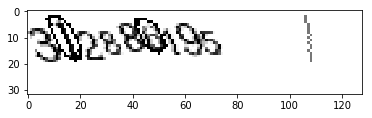

In [6]:
train_generator = ocr.DataGenerator(batch_size=64, x_dim=(32,128), kor_source = kor_train, eng_source = eng_train, text_length = 15, dictionary = dictionary, font_path=font_path,text_generator = ocr.text_img_generator)
test_generator = ocr.DataGenerator(batch_size=500, x_dim=(32,128), kor_source = kor_test, eng_source = eng_test, text_length = 15, dictionary = dictionary, font_path=font_path,text_generator = ocr.text_img_generator)
batch_x, batch_y = train_generator.data_generation()
print(batch_x.shape)
plt.imshow(batch_x[0,:,:,0],cmap = 'gray')
plt.show()

In [7]:
def handmade_generator(x,y,batch_size):
    length = len(x)
    rand_batch = np.random.choice(length,batch_size)
    batch_x = x[rand_batch]
    batch_y = y[rand_batch]
    
    aug = []
    for e in batch_x:
        if np.random.random() < 0.5:
            e = ocr.shift(e,10)
        if np.random.random() < 0.5:
            e = ocr.rotate(e,15)
        if np.random.random() < 0.5:
            e = ocr.g_blur(e,0.5)
        if np.random.random() < 0.5:
            e = ocr.reverse(e)
        if np.random.random() < 0.5:
            e = ocr.shrink(e,0.4)
        if np.random.random() < 0.5:
            e = ocr.tilt(e,20)
        aug.append(e)
    return(np.array(aug),batch_y)

In [ ]:

opt = keras.optimizers.SGD(lr=0.01,decay=0.00001, momentum = 0.5, nesterov = True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
checkpoint_Best = ModelCheckpoint(filepath=save_model_path, verbose=0, save_best_only=True)

epochs = 1
steps_per_epoch = 1
min_loss = 100

for epoch in range(epochs):
    dt1 = datetime.datetime.now()
    for step in range(steps_per_epoch):
        x_batch_gen, y_batch_gen = train_generator.data_generation()
        loss_gen = model.train_on_batch(x_batch_gen,y_batch_gen)
        
    test_loss, test_acc = model.evaluate(test_generator.data_generation(),verbose = 0)
    if test_loss < min_loss:
        min_loss = test_loss
        model.save(save_model_path)

    dt2 = datetime.datetime.now()
    time = dt2-dt1
    print ('epoch: %d, [Train_Loss: %.4f], [Train_Acc: %.2f Percent], [Test_Loss: %.4f], [Test_Acc: %.2f Percent], [Elapsed Time: %.2f Seconds]' % 
           (epoch+1, loss_gen[0], 100*loss_gen[1], test_loss, 100*test_acc, time.total_seconds()))

